In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split,StratifiedKFold, cross_val_score, cross_validate,RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from scipy.stats import randint as sp_randint, uniform as sp_uniform
from imblearn.over_sampling import SMOTE, ADASYN, BorderlineSMOTE
from imblearn.combine import SMOTEENN
from imblearn.pipeline import Pipeline
from lightgbm import LGBMClassifier, early_stopping
import joblib

In [14]:
file = r"c:\Users\Hegazy\Desktop\mine\cumulative.csv"
dfb = pd.read_csv(file, comment="#")
print(dfb.shape)

(9564, 141)


In [15]:
# print(dfb.columns)
# print(dfb.head(3))
# print(dfb.duplicated().sum()) #//0
# print(dfb.dtypes)
# print(dfb.info())
id_col=dfb["koi_disposition"].value_counts()
print("Classes: ",dfb["koi_disposition"].unique())
print(id_col)

Classes:  ['CONFIRMED' 'CANDIDATE' 'FALSE POSITIVE']
koi_disposition
FALSE POSITIVE    4839
CONFIRMED         2746
CANDIDATE         1979
Name: count, dtype: int64


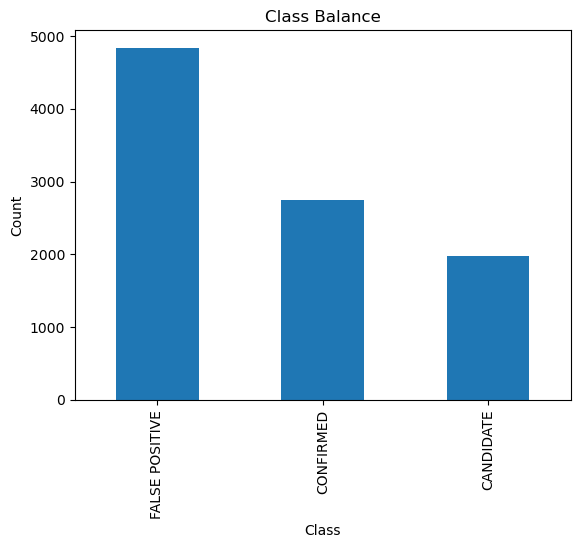

In [16]:
id_col.plot(kind="bar")
plt.xlabel("Class")
plt.ylabel("Count")
plt.title("Class Balance")
plt.show()

In [22]:
# df = dfb[dfb['koi_disposition'] != 'FALSE POSITIVE']

class_data1 = dfb[dfb['koi_disposition'] == 'CONFIRMED']
class_data1_sampled = class_data1.sample(n=2000, random_state=42)
class_data2 = dfb[dfb['koi_disposition'] == 'FALSE POSITIVE']
class_data2_sampled = class_data2.sample(n=2000, random_state=42)
other_classes = dfb[~dfb['koi_disposition'].isin(['CONFIRMED','FALSE POSITIVE'])]
df= pd.concat([class_data1_sampled, class_data2_sampled, other_classes])
v2=df["koi_disposition"].value_counts()
print(v2)

koi_disposition
CONFIRMED         2000
FALSE POSITIVE    2000
CANDIDATE         1979
Name: count, dtype: int64


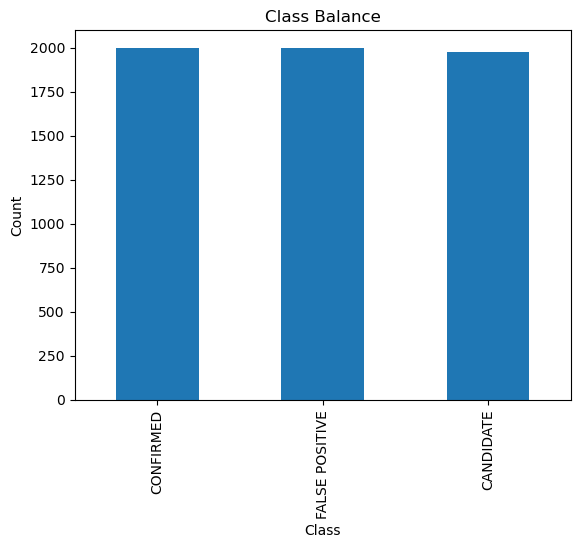

In [18]:
v2.plot(kind="bar")
plt.xlabel("Class")
plt.ylabel("Count")
plt.title("Class Balance")
plt.show()

In [23]:
# print(df.isnull().sum())
nan_cols = df.columns[df.isnull().all()]
df = df.drop(columns=nan_cols)
# print("Nulls:",df.isnull().sum().sum())
# print("Filling NULLS with Median ...")
Y_raw = df["koi_disposition"].copy()
columns_to_drop = ["koi_disposition", "rowid", "kepid", "kepoi_name", "kepler_name", "koi_score"]
df = df.drop(columns=columns_to_drop)
print(f"\nAfter dropping unnecessary columns: {df.shape}")
cols_to_impute = df.select_dtypes(include=np.number).columns
imputer = SimpleImputer(strategy='median')
df[cols_to_impute] = imputer.fit_transform(df[cols_to_impute])
cat_cols = df.select_dtypes(include=['object', 'category']).columns
imputer_cat = SimpleImputer(strategy='most_frequent')
df[cat_cols] = imputer_cat.fit_transform(df[cat_cols])
print("Nulls? :",df.isnull().sum().sum())
# print(df["koi_disposition"].value_counts())
# print(df.shape)


After dropping unnecessary columns: (5979, 116)
Nulls? : 0


In [26]:
encoders = {}
LE_tg = LabelEncoder()
# print(df.select_dtypes(include=["object"]).columns)
Y = LE_tg.fit_transform(Y_raw)
for cl in cat_cols:
    # print(f"Col {cl} contain {df[cl].nunique()}")
    LE_str = LabelEncoder()
    df[cl] = LE_str.fit_transform(df[cl])
    encoders[cl] = LE_str
# print(LE_tg.classes_) 
X = df.copy()
# print(X.columns.tolist())
# print(X.shape)
print(f"\nFinal X shape: {X.shape}")


Final X shape: (5979, 116)


In [27]:
xtr,xtst,ytr,ytst=train_test_split(X,Y,test_size=.2,random_state=42,stratify=Y)
xtr_main, xtr_val, ytr_main, ytr_val = train_test_split(xtr, ytr, test_size=0.25, random_state=42,stratify=ytr)
# corr = pd.DataFrame(xtr.corrwith(pd.Series(ytr))).sort_values(0, ascending=False)
# print(corr.head(20))
smot=SMOTE(random_state=42)
xtr_smt,ytr_smt=smot.fit_resample(xtr_main,ytr_main)
# # smot = BorderlineSMOTE(random_state=42)
# smot = ADASYN(random_state=42)
# xtr_smt, ytr_smt = smot.fit_resample(xtr, ytr)

# smot_enn = SMOTEENN(random_state=42)
# xtr_smt, ytr_smt = smot_enn.fit_resample(xtr_main, ytr_main)

# print("Train classes:", np.unique(ytr_smt))
# print("Val classes:", np.unique(ytr_val))

In [29]:
Mdl = LGBMClassifier(
    n_estimators=600,
    learning_rate=0.005,
    class_weight='balanced',
    random_state=42,
    reg_alpha=0.2,
    reg_lambda=0.2,
    min_child_samples=50,
    verbosity=-1)

Mdl.fit(xtr_smt, ytr_smt,
        eval_set=[(xtr_val, ytr_val)],
        eval_metric='multi_logloss',
        callbacks=[early_stopping(50, first_metric_only=True)])


# param_dist = {
#     'n_estimators': sp_randint(400, 1500),
#     'learning_rate': sp_uniform(0.005, 0.045),
#     'num_leaves': sp_randint(20, 100),
#     'max_depth': sp_randint(5, 15),
#     'min_child_samples': sp_randint(10, 50),
#     'reg_alpha': sp_uniform(0.1, 1.0),
#     'reg_lambda': sp_uniform(0.1, 1.0),
#     'colsample_bytree': sp_uniform(0.7, 0.9),
#     'subsample': sp_uniform(0.7, 0.9),
#     'subsample_freq': sp_randint(1, 7),
#     'objective': ['multiclass'],
#     'num_class': [len(LE_tg.classes_)],
#     'class_weight': ['balanced'], 
#     'random_state': [42],
#     'n_jobs': [-1],
#     'verbose': [-1]}

# lgbm = LGBMClassifier()

# random_search = RandomizedSearchCV(
#     estimator=lgbm, 
#     param_distributions=param_dist,
#     n_iter=50,
#     scoring='f1_weighted',
#     cv=5,
#     verbose=1,
#     random_state=42,
#     n_jobs=-1)

# print("Starting Randomized Search for LightGBM hyperparameters...")
# random_search.fit(xtr_smt, ytr_smt)

# print("\n"+"="*50)
# print("Best Hyperparameters Found:")
# print(random_search.best_params_)
# print(f"Best CV F1-Weighted Score: {random_search.best_score_:.4f}")
# print("="*50)

# Mdl = random_search.best_estimator_

# Mdl = RandomForestClassifier(
#     n_estimators=300,
#     class_weight='balanced',
#     random_state=42,
#     min_samples_split=2,
#     min_samples_leaf=1, 
#     max_features='sqrt',
#     n_jobs=-1)

# Mdl.fit(xtr_smt, ytr_smt)
# # Evaluate manually on validation
# y_val_pred = Mdl.predict(xtr_val)
# print(classification_report(ytr_val, y_val_pred))

Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[600]	valid_0's multi_logloss: 0.198124
Evaluated only: multi_logloss


LGBMClassifier(class_weight='balanced', learning_rate=0.005,
               min_child_samples=50, n_estimators=600, random_state=42,
               reg_alpha=0.2, reg_lambda=0.2, verbosity=-1)

In [30]:
#Evaluate on TRAIN
ytrain_pred = Mdl.predict(xtr_smt)
print("\nTrain classification report:")
print(classification_report(ytr_smt, ytrain_pred))

#Evaluate on TEST
ytest_pred = Mdl.predict(xtst)
print("\nTest classification report:")
print(classification_report(ytst, ytest_pred))


Train classification report:
              precision    recall  f1-score   support

           0       0.98      0.97      0.97      1200
           1       0.97      0.97      0.97      1200
           2       1.00      1.00      1.00      1200

    accuracy                           0.98      3600
   macro avg       0.98      0.98      0.98      3600
weighted avg       0.98      0.98      0.98      3600


Test classification report:
              precision    recall  f1-score   support

           0       0.90      0.91      0.91       396
           1       0.91      0.90      0.90       400
           2       1.00      1.00      1.00       400

    accuracy                           0.94      1196
   macro avg       0.94      0.94      0.94      1196
weighted avg       0.94      0.94      0.94      1196



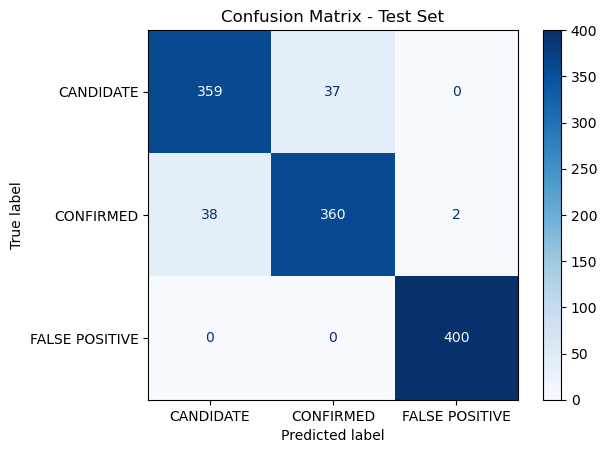

In [31]:
cm = confusion_matrix(ytst, ytest_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=LE_tg.classes_)
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix - Test Set")
plt.show()

In [32]:
joblib.dump(Mdl, 'exoplanet_model.pkl')
joblib.dump(LE_tg, 'label_encoder.pkl')
joblib.dump(X.columns.tolist(), 'feature_columns.pkl')
joblib.dump(encoders, 'feature_encoders.pkl')
joblib.dump(imputer, 'imputer_numeric.pkl')
joblib.dump(imputer_cat, 'imputer_cat.pkl')
joblib.dump(cols_to_impute.tolist(), 'numeric_columns.pkl')
joblib.dump(cat_cols.tolist(), 'cat_columns.pkl')
print("Model and preprocessing objects saved successfully!")

Model and preprocessing objects saved successfully!


In [33]:
print(f"Feature columns: {len(X.columns.tolist())} features")
print(f"Numeric columns: {len(cols_to_impute)}")
print(f"Categorical columns: {len(cat_cols)}")

Feature columns: 116 features
Numeric columns: 103
Categorical columns: 13
